<a href="https://colab.research.google.com/github/mhaque4/mhaque4/blob/main/Copy_of_Customersegmention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1 Imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans


In [ ]:
#Reading csv file and checking data types and null value information using info
data = pd.read_csv("D:\MASROOR\PROJECT\Online Retail.csv", encoding = "ISO-8859-1")
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
# Data Cleaning and EDA
# Checking for duplicates if any present
print("Shape before dropping duplicates", data.shape)
data = data.drop_duplicates()
print("Shape after dropping duplicates", data.shape)

Shape before dropping duplicates (541909, 8)
Shape after dropping duplicates (536641, 8)


In [ ]:
# Checking Data Shape and Unique Values in different columns
print("Data Shape", data.shape)
for col in ["InvoiceNo","StockCode","InvoiceDate","CustomerID", "Country"]:
    print("Unique Values for ", col, " - ", data[col].nunique())

Data Shape (536641, 8)
Unique Values for  InvoiceNo  -  25900
Unique Values for  StockCode  -  4070
Unique Values for  InvoiceDate  -  23260
Unique Values for  CustomerID  -  4372
Unique Values for  Country  -  38


In [ ]:
#Checking Nulls in CustomerID
print(np.sum(data.isnull()), "\n")
print("Percentage of customers missing: ", round(data['CustomerID'].isnull().sum() * 100 / len(data),2),"%" )

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64 

Percentage of customers missing:  25.16 %


In [ ]:
# Check if InvoiceNo for Null Customer ID exist in cases where Customer ID is present for filling CustomerID Nulls
# No such cases present as empty dataframe is returned
null_id_invoices = data[data.CustomerID.isnull()]["InvoiceNo"].drop_duplicates().tolist()
print("Invoices count with Null Customer ID", len(null_id_invoices))
### Check if InvoiceNo in Null CustomerID dataframe exist in Non-Null Customer ID Dataframe
data[~data.CustomerID.isnull()][data.InvoiceNo.isin(null_id_invoices)]

Invoices count with Null Customer ID 3710


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [ ]:
# Check if InvoiceNo has unique mapping with Customer ID so that each InvoiceNo corresponding to Null CustomerID can be assigned as New Customer
data.groupby(['InvoiceNo'])['CustomerID'] \
                             .nunique() \
                             .reset_index(name='nunique') \
                             .sort_values(['nunique'], ascending=False) \
                             .head(5)


,InvoiceNo,nunique
0,536365,1
16915,571200,1
16924,571215,1
16923,571214,1
16922,571213,1


In [ ]:
# Creating NewID column and Assigning to InvoiceNo wherever CustomerID is null
data['NewID'] = data['CustomerID']
data.loc[data['CustomerID'].isnull(), ['NewID']] = data['InvoiceNo']

#Remove all non digits from column NewID (Since Invoice can contains "C" referring to cancellations)
data['NewID'] = data['NewID'].astype(str).str.replace('\D+', '')

#Convert to integer
data['NewID'] = pd.to_numeric(data['NewID'])

### Check if presnt customerIds and New Ids have any common values since it would create alter actual Customer Insights
customer = data['CustomerID'].nunique()
null_invoices = data[data.CustomerID.isnull()]['InvoiceNo'].nunique()
new_ids = data['NewID'].nunique()
print("Number of Customers:", customer)
print("Number of Orders where CustomerID in Null:", null_invoices)
print("Number of Customers + Number of Orders where CustomerID in Null:", customer + null_invoices)
print("Number of New ID's:", new_ids)

Number of Customers: 4372
Number of Orders where CustomerID in Null: 3710
Number of Customers + Number of Orders where CustomerID in Null: 8082
Number of New ID's: 8082


In [ ]:
# Converting object type to datetime for InvoiceDate and checking first and last dates
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
print("Minimum Invoice Date", min(data["InvoiceDate"]))
print("Maximum Invoice Date", max(data["InvoiceDate"]))

Minimum Invoice Date 2010-01-12 08:26:00
Maximum Invoice Date 2011-12-10 17:19:00


In [ ]:
#Adding cancellations column based on definition that InvoiceNo starts with C
data["cancellations"] = np.where(data["InvoiceNo"].str.startswith('C'), 1,0)
total_data = data["InvoiceNo"].shape[0]
cancelled_data = data[data.cancellations == 1].shape[0]
print("Number of cancelled products data", cancelled_data, cancelled_data*100/total_data, "\n")

print(data[data.cancellations == 1]["Quantity"].describe())

#### Removing cancellations since they have negative quantities and makes only ~2% of data
data = data[data.cancellations == 0]

Number of cancelled products data 9251 1.7238712658928408 

count     9251.000000
mean       -29.787050
std       1147.997592
min     -80995.000000
25%         -6.000000
50%         -2.000000
75%         -1.000000
max         -1.000000
Name: Quantity, dtype: float64


In [ ]:
# Analysis of UnitPrice variable
print("Minimum UnitPrice", min(data["UnitPrice"]))
print("Maximum UnitPrice", max(data["UnitPrice"]))
data["UnitPrice"].describe()

Minimum UnitPrice -11062.06
Maximum UnitPrice 13541.33


count    527390.000000
mean          3.861939
std          41.963759
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

In [ ]:
#checking cases where Price <0
data[data.UnitPrice<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,NewID,cancellations
299983,A563186,B,Adjust bad debt,1,2011-12-08 14:51:00,-11062.06,NaN,United Kingdom,563186,0
299984,A563187,B,Adjust bad debt,1,2011-12-08 14:52:00,-11062.06,NaN,United Kingdom,563187,0


In [ ]:
# Removing these two cases
data = data[data.UnitPrice >= 0]

In [ ]:
# All rows where Price == 0
print("% of data with Price = 0: ", round(len(data[data.UnitPrice == 0]) * 100 / len(data),2),"%" )
print("Count of unique Customer ID values ", data[data.UnitPrice == 0].CustomerID.nunique(), "\n")
data[data.UnitPrice == 0][~data.CustomerID.isnull()].head()

% of data with Price = 0:  0.48 %
Count of unique Customer ID values  31 



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,NewID,cancellations
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-05-12 14:02:00,0.0,12647.0,Germany,126470,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,165600,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,149110,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-06-01 16:41:00,0.0,13081.0,United Kingdom,130810,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-06-01 16:41:00,0.0,13081.0,United Kingdom,130810,0


In [ ]:
### Dropping Cases with UnitPrice = 0
data_filtered = data[data.UnitPrice >0]
data_filtered["UnitPrice"].describe()

count    524878.000000
mean          3.922573
std          36.093028
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

In [ ]:
print("Minimum Quantity", min(data_filtered["Quantity"]))
print("Maximum Quantity", max(data_filtered["Quantity"]))
data_filtered["Quantity"].describe()

Minimum Quantity 1
Maximum Quantity 80995


count    524878.000000
mean         10.616600
std         156.280031
min           1.000000
25%           1.000000
50%           4.000000
75%          11.000000
max       80995.000000
Name: Quantity, dtype: float64

# Customer and total revenue split wrto country


In [ ]:
### Adding Monetary information by calculating total value of transaction by multiplying unit price and quantity of the product
data_filtered["Total_sales"] = data_filtered["UnitPrice"]*data_filtered["Quantity"]

### Creating Country Level grouping to find Unique Customer count and %
country_customer_df = data_filtered.groupby("Country")["CustomerID"].nunique().reset_index().rename(columns = \
                                                                                           {"CustomerID":"count_CustomerID"})
country_customer_df["customer_%"] = round(country_customer_df["count_CustomerID"]*\
                                          100/country_customer_df["count_CustomerID"].sum(),2)

### Creating Country Level grouping to find total revenue and %
country_df = data_filtered.groupby("Country")["Total_sales"].sum().reset_index()
country_df["Total_sales%"] = round(country_df["Total_sales"]*100/country_df["Total_sales"].sum(),2)

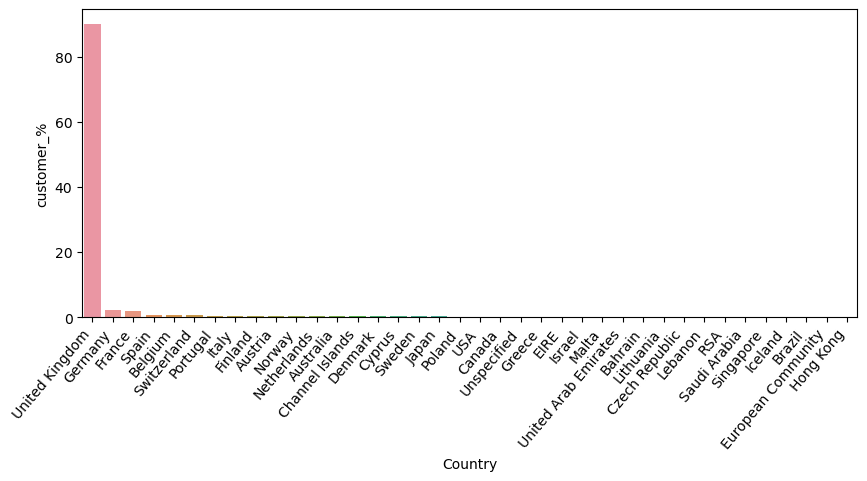

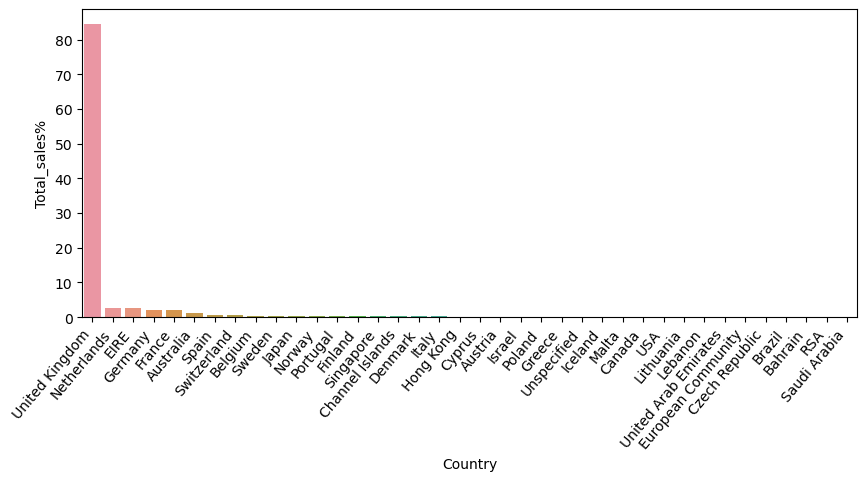

In [ ]:
country_customer_df = country_customer_df.sort_values(by = "customer_%", ascending = False)
fig, ax = plt.subplots(figsize=(10,4),dpi=100)
ax=sns.barplot(x=country_customer_df["Country"], y=country_customer_df['customer_%'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

country_df = country_df.sort_values(by = "Total_sales%", ascending = False)
fig, ax = plt.subplots(figsize=(10,4),dpi=100)
ax=sns.barplot(x=country_df["Country"], y=country_df['Total_sales%'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

In [ ]:
# The United Kingdom not only has the most sales revenue, but also the most customers. Therefore, for the purpose of this analysis, I will be taking data corresponding to orders from the United Kingdom.
uk_df = data_filtered[data_filtered.Country == "United Kingdom"]
uk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 479985 entries, 0 to 541893
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   InvoiceNo      479985 non-null  object        
 1   StockCode      479985 non-null  object        
 2   Description    479985 non-null  object        
 3   Quantity       479985 non-null  int64         
 4   InvoiceDate    479985 non-null  datetime64[ns]
 5   UnitPrice      479985 non-null  float64       
 6   CustomerID     349203 non-null  float64       
 7   Country        479985 non-null  object        
 8   NewID          479985 non-null  int64         
 9   cancellations  479985 non-null  int32         
 10  Total_sales    479985 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(2), object(4)
memory usage: 42.1+ MB


In [ ]:
# Checking Most popular products in United Kingdom
uk_product = uk_df.groupby(['StockCode','Description'],as_index= False)['Quantity'].sum().sort_values(by='Quantity', \
                                                                                                      ascending=False)
uk_product.head(5)

,StockCode,Description,Quantity
2653,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
2112,23166,MEDIUM CERAMIC TOP STORAGE JAR,77036
3113,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,49430
3601,85099B,JUMBO BAG RED RETROSPOT,44161
3622,85123A,WHITE HANGING HEART T-LIGHT HOLDER,35430


In [ ]:
#Find the unique number of InvoiceNo  per customer for analysis of United Kingdom
groupby_customers = pd.DataFrame(uk_df.groupby('NewID')['InvoiceNo'].nunique())
groupby_customers.describe()

,InvoiceNo
count,5293.000000
mean,3.404308
std,6.356634
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,209.000000


In [ ]:
#Find the unique number of products per Order
groupby_invoice = pd.DataFrame(uk_df.groupby('InvoiceNo')['StockCode'].nunique())
groupby_invoice.columns = ['Number of products per Order']
groupby_invoice.describe()

,Number of products per Order
count,18019.000000
mean,26.351129
std,48.882851
min,1.000000
25%,6.000000
50%,15.000000
75%,29.000000
max,1110.000000


In [ ]:
#RFM Segmentation
#Recency (R) of a customer: Days since the last purchase.
# Frequency (F) of the bookings/turnover of a customer: Number of purchases, e.g., in 6 months.
# Monetary (M) - The total turnover of a customer: Sum of sales, e.g., in 6 months.
#For the analysis, we need to define a ‘analysis date’, which is the day on which we are conducting this analysis which I am taking as the next to last date in data and taking 1 year previous data from the selected date for recency calculation
analysis_date = uk_df["InvoiceDate"].max() + pd.DateOffset(1)
print("RFM Analysis Date :", analysis_date)

start_date = analysis_date - pd.DateOffset(days = 365)
print("Start Date when taking 1 year data for analysis :", start_date)

RFM Analysis Date : 2011-12-11 17:19:00
Start Date when taking 1 year data for analysis : 2010-12-11 17:19:00


In [ ]:
### Drop Nulls in CUstomerID
uk_df = uk_df[~uk_df.CustomerID.isnull()]

# Aggregate data on a customer level to get RFM values
data_rfm = uk_df[uk_df.InvoiceDate >= start_date].groupby(['NewID'],as_index=False).agg({'InvoiceDate': lambda x: (analysis_date - x.max()).days,
'InvoiceNo': 'count','Total_sales': 'sum'}).rename(columns = {'InvoiceDate': 'Recency', \
                                            'InvoiceNo': 'Frequency','Total_sales': 'Monetary'})
data_rfm.head()

,NewID,Recency,Frequency,Monetary
0,123460,327,1,77183.60
1,127470,24,96,3837.45
2,127480,5,3883,29674.51
3,127490,24,199,4090.88
4,128200,46,59,942.34


In [ ]:
### Getting individual RFM scores by using quantiles for each of the columns
data_rfm['R_score'] = pd.qcut(data_rfm['Recency'], 4, labels=False)
data_rfm['F_score'] = pd.qcut(data_rfm['Frequency'], 4, labels=False)
data_rfm['M_score'] = pd.qcut(data_rfm['Monetary'], 4, labels=False)

### Since a low Recency score means recent transactions and good customer, changine quantile values
### so that low values rank highest ans vice versa
data_rfm['R_score'] = 3 - data_rfm['R_score']

data_rfm['RFM'] = data_rfm.R_score.map(str) \
                            + data_rfm.F_score.map(str) \
                            + data_rfm.M_score.map(str)

### Calculating Final RFM score
data_rfm["RFM_Score"] = data_rfm['R_score'] + data_rfm['F_score'] + data_rfm['M_score']
data_rfm.head(10)

,NewID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM,RFM_Score
0,123460,327,1,77183.60,0,0,3,003,3
1,127470,24,96,3837.45,2,2,3,223,7
2,127480,5,3883,29674.51,3,3,3,333,9
3,127490,24,199,4090.88,2,3,3,233,8
4,128200,46,59,942.34,2,2,2,222,6
5,128210,97,6,92.72,1,0,0,100,1
6,128220,72,46,948.88,1,2,2,122,5
7,128230,76,5,1759.50,1,0,3,103,4
8,128240,31,25,397.12,2,1,1,211,4
9,128260,61,82,1319.72,2,2,2,222,6


In [ ]:
#The RFM_Score values will range from 0 (0+0+0) to 9 (3+3+3). Now grouping by the RFM scores to check the mean values of recency, frequency, and monetary corresponding to each score.
data_rfm.groupby("RFM_Score")[['Recency','Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
RFM_Score,,,
0,247.649518,7.581994,146.476463
1,183.753623,13.895652,220.795188
2,160.032120,20.815846,342.064799
3,104.979638,26.667421,627.106676
4,97.309091,39.257143,1266.646987
5,66.700000,52.407317,1024.498417
6,55.210084,74.120448,1372.810087
7,40.436548,118.763959,1817.034188
8,26.517241,181.846154,3930.945623


Modeling : K - Means Clustering

                ----------------- Distribution Plots for R,F,M -------------------------------


<AxesSubplot:xlabel='Monetary', ylabel='Density'>

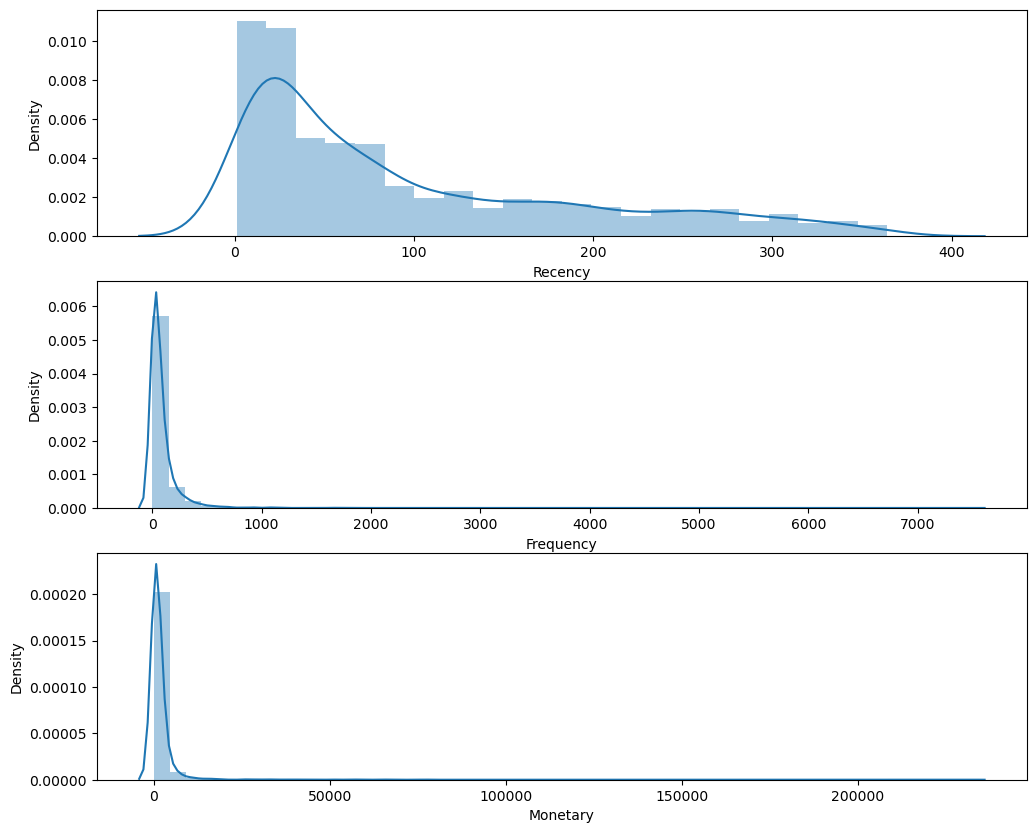

In [ ]:
print("                ----------------- Distribution Plots for R,F,M -------------------------------")

# Checking the distribution of Recency, Frequency and MonetaryValue variables.
plt.figure(figsize=(12,10))
# Plot distribution of var1
plt.subplot(3, 1, 1); sns.distplot(data_rfm['Recency'])
# Plot distribution of var2
plt.subplot(3, 1, 2); sns.distplot(data_rfm['Frequency'])
# Plot distribution of var3
plt.subplot(3, 1, 3); sns.distplot(data_rfm['Monetary'])

                ----------------- Log Transformation Plots for R,F,M -------------------------------


<AxesSubplot:xlabel='log_M', ylabel='Density'>

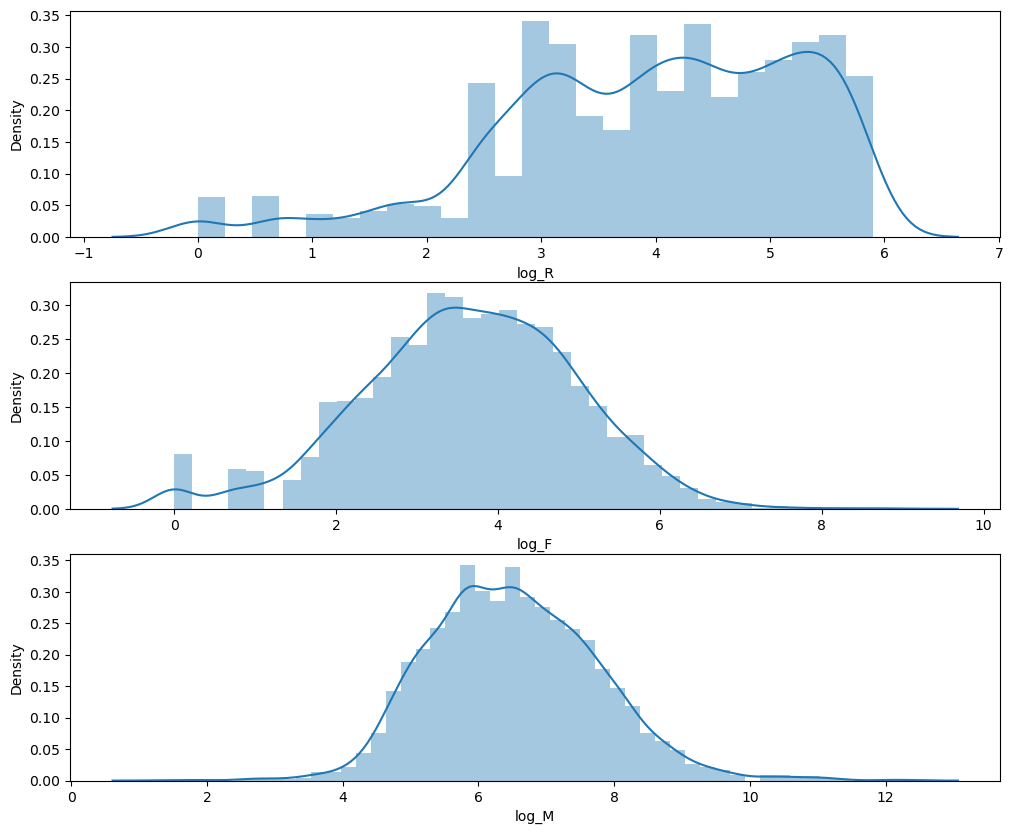

In [ ]:
# Taking Log of columns
data_rfm["log_R"] = np.log(data_rfm.Recency)
data_rfm["log_F"] = np.log(data_rfm.Frequency)
data_rfm["log_M"] = np.log(data_rfm.Monetary)

# Checking the distribution of Recency, Frequency and Monetary variables after log transformation
print("                ----------------- Log Transformation Plots for R,F,M -------------------------------")
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1)
sns.distplot(data_rfm['log_R'])
plt.subplot(3, 1, 2)
sns.distplot(data_rfm['log_F'])
plt.subplot(3, 1, 3)
sns.distplot(data_rfm['log_M'])

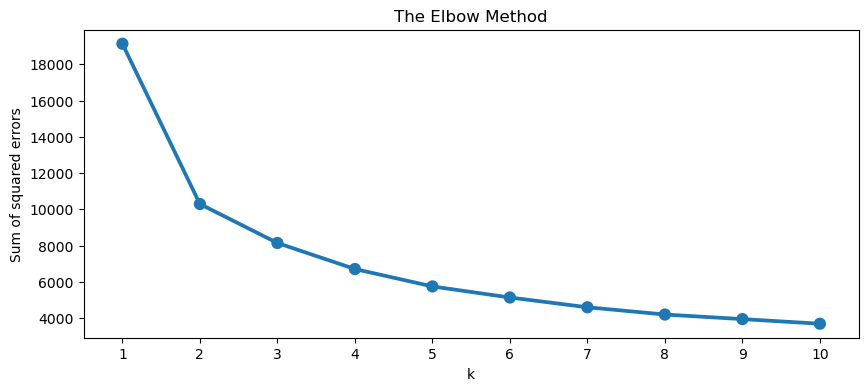

In [ ]:
### Features Used in training K Means - Log Transformed Recency, Frequency and Monetary values
data_norm = data_rfm[["log_R", "log_F", "log_M"]]

sse = {}
# Fit KMeans and calculate SSE for each k
for k in range(1, 11):

    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)

    # Fit KMeans on the normalized dataset
    kmeans.fit(data_norm)

    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

# Plotting the elbow plot
plt.figure(figsize=(10,4))
plt.title('The Elbow Method')
plt.xlabel('k');
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters, random_state=1)
kmeans.fit(data_norm)
data_rfm["cluster"] = kmeans.predict(data_norm)

In [ ]:
#Checking Mean RFM values in different clusters to understand cluster properties
data_rfm.groupby(["cluster"])[['Recency','Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
cluster,,,
0,166.714512,13.103886,267.649739
1,91.150437,59.147940,1021.386438
2,20.135903,226.821501,5076.267363


<AxesSubplot:>

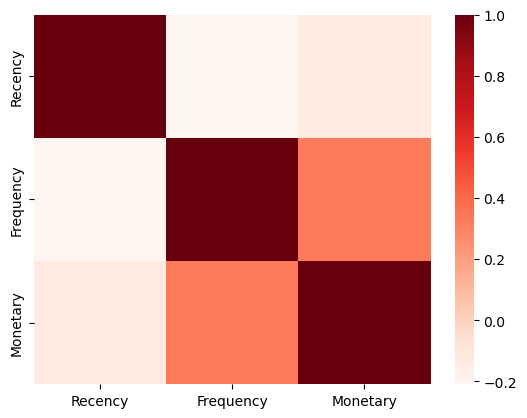

In [ ]:
sns.heatmap(data_rfm[['Recency','Frequency', 'Monetary']].corr(),cmap="Reds")

Text(0, 0.5, 'Monetary')

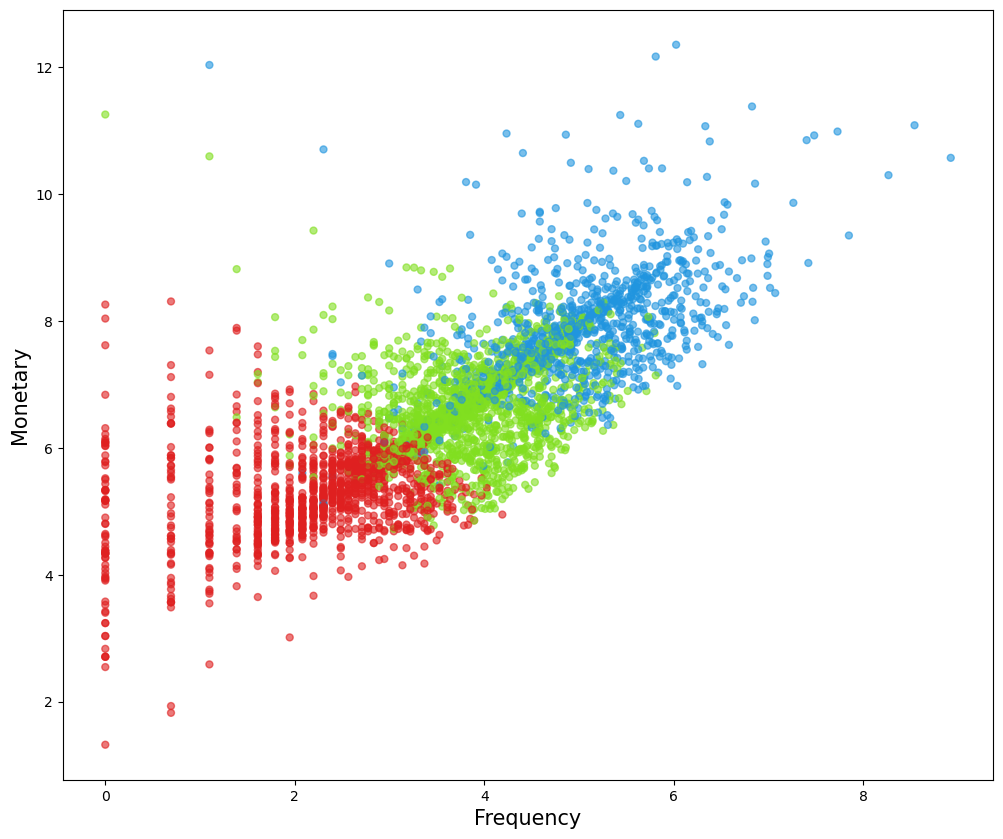

In [ ]:
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids]
cen_y = [i[1] for i in centroids]

## add to dataframe
data_rfm['cen_x'] = data_rfm.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
data_rfm['cen_y'] = data_rfm.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
data_rfm['c'] = data_rfm.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

# Plot clusters
plt.figure(figsize=(12,10))
plt.scatter(data_rfm.log_F, data_rfm.log_M, c=data_rfm.c, alpha = 0.6, s=25)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Monetary', fontsize=15)